In [18]:
import os
from joblib import Parallel, delayed
import argparse
import numpy as np
import joblib
from econml.dr import DRLearner
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from econml.dml import NonParamDML
import warnings
warnings.simplefilter('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [26]:
#here we replicate steup A, sigma is the standard deviation of the noise
def gen_data(n,d, base_fn, tau_fn, prop_fn, sigma):
    X = np.random.uniform(0,1, size = (n,d))
    X_test = np.random.uniform(0,1, size = (10000, d))
    T = np.random.binomial(1, prop_fn(X)) #here, 1 refers to number of trials, 1 reduces the binomial distribution to a bernoulli distribution
    y = (T - .5)*tau_fn(X) + base_fn(X) + sigma*np.random.normal(0,1, size = (n,))
    return y, T, X, X_test

def get_data_generator(n, d, sigma):
        def base_fn(X): return np.sin(np.pi * X[:, 0] * X[:, 1]) + 2*(X[:, 2] - .5)**2 + X[:, 3] + .5*X[:, 4]
        def prop_fn(X): return np.clip(
            np.sin(np.pi * X[:, 0] * X[:, 1]), .2, .8)
        def tau_fn(X): return .2 + (X[:, 0] + X[:, 1]) / 2
        def gen_data_fn(): return gen_data(
            n, d, base_fn, tau_fn, prop_fn, sigma)
        return gen_data_fn, base_fn, tau_fn, prop_fn

def rmse(ytrue, y):
    return np.sqrt(np.mean((ytrue.flatten() - y.flatten())**2))

def exp(y, T, X, Xtest, method_list, tau_fn, n_x):
    results = {}
    for name, method in method_list:
        #print(name)
        tau_est, _ = method(y, T, X, Xtest, n_x)
        results[name] = rmse(tau_fn(Xtest), tau_est)**2 #sme results
        # print(results[name])
        # print('-'*10)
        bias = np.mean(tau_est) - np.mean(tau_fn(Xtest))
    return results, bias

from flaml import AutoML
from sklearn.base import BaseEstimator, clone

class AutoMLWrap(BaseEstimator):
    def __init__(self, *, model):
        self.model = model
    def fit(self, X, y, **kwargs):
        self.model_ = clone(self.model)
        self.model_.fit(X, y, **kwargs)
        return self
    def predict(self, X):
        return self.model_.predict(X)
    def predict_proba(self, X):
        return self.model_.predict_proba(X)

def first_stage_reg(X, y): #predicting the base response function
    automl = AutoML(task='regression', time_budget=60, early_stop=True,
                    eval_method='cv', n_splits=5, metric='mse', verbose=0)
    automl.fit(X, y)
    best_est = automl.best_estimator 
    return AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)))


def first_stage_clf(X, y): #predicting the propensities
    automl = AutoML(task='classification', time_budget=60, early_stop=True,
                    eval_method='cv', n_splits=5, metric='mse', verbose=0)
    automl.fit(X, y)
    best_est = automl.best_estimator
    return AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)))

def final_stage():#predicting the CATE
    return AutoMLWrap(model=AutoML(task='regression', time_budget=60, early_stop=True,
                                   eval_method='cv',
                                   n_splits=10, metric='mse', verbose=0))#original code use a customized weighted mse

def s_learner(y, T, X, Xtest, n_x):
    model = Ridge(alpha = 1.0)
    model.fit(np.hstack((X, T.reshape(-1, 1))), y)
    y0_pred = model.predict(np.hstack((Xtest, np.zeros((Xtest.shape[0], 1)))))
    y1_pred = model.predict(np.hstack((Xtest, np.ones((Xtest.shape[0], 1)))))
    return y1_pred - y0_pred, model

def dml(y, T, X, Xtest, n_x): #10-fold cross-fitting
    est = NonParamDML(model_y='auto',
                      model_t='auto',
                      model_final=final_stage(),
                      discrete_treatment=True,
                      cv=10,
                      random_state=123)
    est.fit(Y=y, T=T, X=X[:, :n_x], W=X[:, n_x:])
    print("models_t",est.models_t)
    print("models_y",est.models_y)
    return est.effect(Xtest[:, :n_x]), est



In [25]:
gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(1000, 6, 0.5)
y, T, X, Xtest = gen_data_fn()
print(y.shape, T.shape, X.shape, Xtest.shape)
exp(y, T, X, Xtest, [('dml', dml)], tau_fn, n_x=4)

(1000,) (1000,) (1000, 6) (10000, 6)
models_t [[LogisticRegression(C=2.782559402207126, intercept_scaling=1.0, random_state=123), LogisticRegression(C=2.782559402207126, intercept_scaling=1.0, random_state=123), LogisticRegression(C=2.782559402207126, intercept_scaling=1.0, random_state=123), LogisticRegression(C=2.782559402207126, intercept_scaling=1.0, random_state=123), LogisticRegression(C=2.782559402207126, intercept_scaling=1.0, random_state=123), LogisticRegression(C=2.782559402207126, intercept_scaling=1.0, random_state=123), LogisticRegression(C=2.782559402207126, intercept_scaling=1.0, random_state=123), LogisticRegression(C=2.782559402207126, intercept_scaling=1.0, random_state=123), LogisticRegression(C=2.782559402207126, intercept_scaling=1.0, random_state=123), LogisticRegression(C=2.782559402207126, intercept_scaling=1.0, random_state=123)]]
models_y [[RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123

({'dml': 0.17036140433218822}, -0.09481872116429735)

models_t [[RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123)]]
models_y [[RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123)]]
simulated N =  0
models_t [[RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_stat

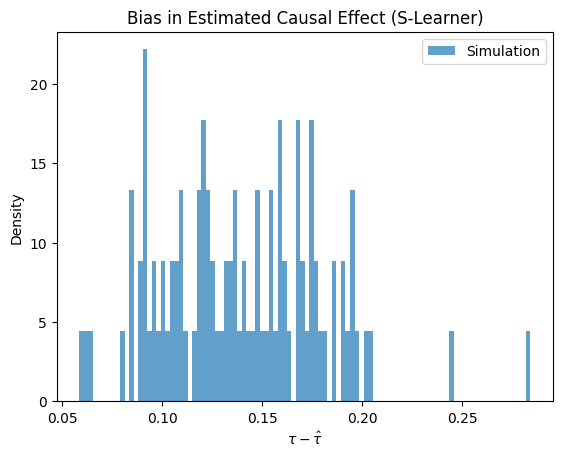

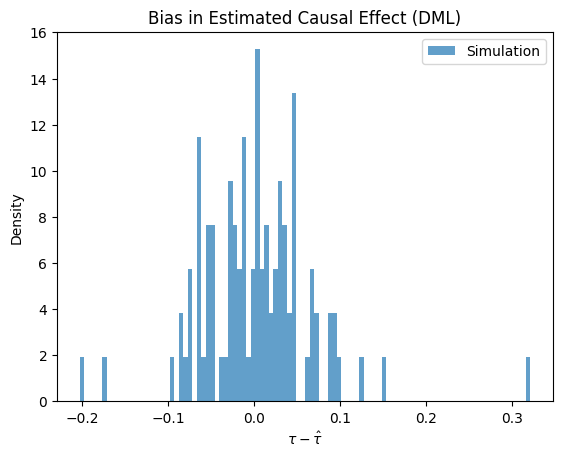

In [28]:
n_simulation = 100
bias_lst_s = []
bias_lst_d = []
for i in range(n_simulation):
    y, T, X, Xtest = gen_data_fn()
    rmse_results, bias = exp(y, T, X, Xtest, [('s-learner', s_learner)], tau_fn, n_x=4)
    bias_lst_s.append(bias)
    rmse_results, bias = exp(y, T, X, Xtest, [('dml', dml)], tau_fn, n_x=4)
    bias_lst_d.append(bias)
    if i % 10 == 0:
        print('simulated N = ',i)
#plotting the results bias distributions
# Plot the results
plt.hist(bias_lst_s, bins=100, density=True, alpha=0.7, label="Simulation")
plt.title("Bias in Estimated Causal Effect (S-Learner)")
plt.xlabel(r"$\tau - \hat{\tau}$")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.hist(bias_lst_d, bins=100, density=True, alpha=0.7, label="Simulation")
plt.title("Bias in Estimated Causal Effect (DML)")
plt.xlabel(r"$\tau - \hat{\tau}$")
plt.ylabel("Density")
plt.legend()
plt.show()
